In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import inv, sqrtm
from numpy import identity as eye
import matplotlib.pyplot as plt
import random
class Calculation:
    def __init__(self, F=8.0, N=40, dt=0.05):
        self.F = F
        self.N = N
        self.dt = dt
        self.u = np.full(self.N, self.F) + np.random.rand(self.N)

    def L96(self, x):
        N = self.N
        F = self.F
        dxdt = np.zeros((N))
        for i in range(2, N-1):
            dxdt[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i] + F
        dxdt[0] = (x[1] - x[N-2]) * x[N-1] - x[0] + F
        dxdt[1] = (x[2] - x[N-1]) * x[0] - x[1] + F
        dxdt[N-1] = (x[0] - x[N-3]) * x[N-2] - x[N-1] + F
        return dxdt

    def Rk4(self, xold):
        dt = self.dt
        k1 = self.L96(xold)
        k2 = self.L96(xold + k1 * dt / 2.)
        k3 = self.L96(xold + k2 * dt / 2.)
        k4 = self.L96(xold + k3 * dt)
        xnew = xold + dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        return xnew

    def RMS(self, x):
        return np.sqrt(np.mean(x**2))

    def trRMS(self, x):
        return np.sqrt(x / self.N)

    def column_means(self, array):
        return np.mean(array, axis=0).tolist()

    def obs_remove(self, obs_point, y, H, R, method=0):
        rmv_point = self.N - obs_point
        methods = [0, 1, 2, 3]
        if method in methods:
            if method == 0:
                return y, H, R
            # 連続抜き
            elif method == 1:
                indices_to_remove = np.s_[0:rmv_point]
                y = np.delete(y, indices_to_remove, axis=1)
                H = np.delete(H, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=1)
                return y, H, R

            # 等間隔抜き
            elif method == 2:
                indices_to_remove = np.linspace(
                    0, self.N - 1, rmv_point, dtype=int)
                y = np.delete(y, indices_to_remove, axis=1)
                H = np.delete(H, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=1)
                return y, H, R

            else:
                indices_to_remove = np.random.choice(
                    self.N, rmv_point, replace=False)
                y = np.delete(y, indices_to_remove)
                H = np.delete(H, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=0)
                R = np.delete(R, indices_to_remove, axis=1)
                return y, H, R

        else:
            print("Wrong method was selected")

    def localization(self, i, j, dist=2.0):
        return np.exp(-(i - j) ** 2 / dist)
cal = Calculation()

In [11]:
class PO:
    def __init__(self, calculation=cal, obs_point=40, method=0):
        self.F = 8.0
        self.N = 40
        self.dt = 0.05
        self.days = 365
        self.day_steps = int(0.20 / self.dt)
        self.time_step = self.days * self.day_steps
        self.ls_time_step = [i for i in range(self.time_step)]
        self.IN = np.eye(self.N)
        self.obs_point = obs_point
        self.df_x_true = pd.read_csv('t_data.csv', header=0, index_col=0)
        self.df_y = pd.read_csv('o_data.csv', header=0, index_col=0)
        self.H = np.eye(self.N)
        self.R = np.eye(self.N)
        self.cal = calculation
        self.method = method
        self.delta = 0.001
        # 以下新変数
        self.member = 1000

    def run_simulation(self):
        x_true = self.df_x_true.values
        y = self.df_y.values
        ua = np.zeros((self.N, self.member))
        uf = np.zeros((self.N, self.member))
        dxf = np.zeros((self.N, self.member))
        error_f, error_a = [], []
        # アンサンブルメンバー作成
        for m in range(self.member):
            # それぞれ初期に乱数擾乱加えてモデル回す
            ua[:, m] = np.random.rand(self.N) + self.F
            for i in range(self.time_step):
                ua[:, m] = self.cal.Rk4(ua[:, m])

        for i in range(self.time_step):
            # forecast step
            for m in range(self.member):
                uf[:, m] = self.cal.Rk4(ua[:, m])
            # 平均計算（axis=1方向の平均）
            mean_uf = np.zeros(self.N)
            for n in range(self.N):
                mean_uf[n] = np.mean(uf[n, :])
            # dxf計算
            for m in range(self.member):
                dxf[:, m] = uf[:, m] - mean_uf
            Pf = 1.1 * ((dxf @ dxf.T) / (self.member - 1))

            # analysis step
            K = Pf @ self.H.T @ np.linalg.inv(self.H @ Pf @ self.H.T + self.R)
            for m in range(self.member):
                # 観測データ作成時に観測誤差分布はnp.random.randとした
                ua[:, m] = uf[:, m] + \
                    K @ ((y[i, :] + np.random.rand(self.N)) -
                         (self.H @ uf[:, m]))
            error_a.append(np.linalg.norm(
                x_true[i, :] - np.mean(ua, axis=1)) / np.sqrt(self.N))
            error_f.append(np.linalg.norm(
                x_true[i, :] - np.mean(uf, axis=1)) / np.sqrt(self.N))

        return error_a, error_f


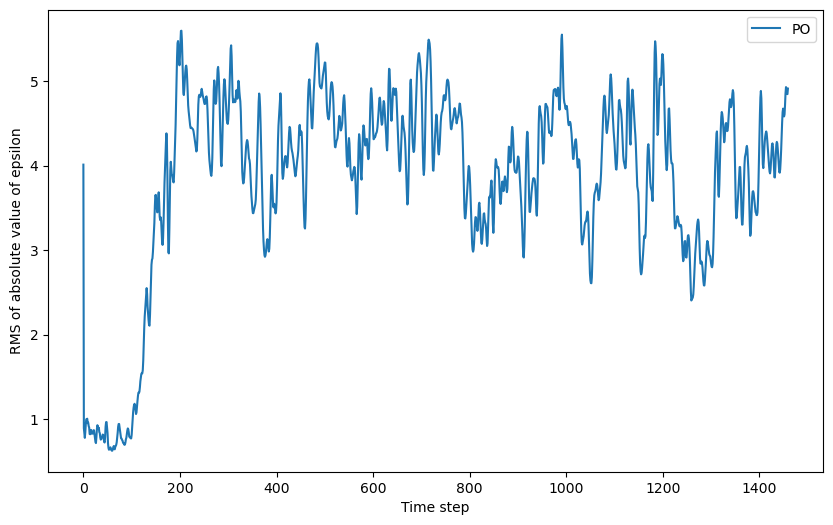

In [12]:
po = PO()
po_1, po_2 = po.run_simulation()
ls = range(len(po_2))
plt.figure(figsize=(10, 6))
plt.xlabel('Time step')
plt.ylabel('RMS of absolute value of epsilon')
plt.plot(ls, po_2, label="PO")
plt.legend()
plt.show()

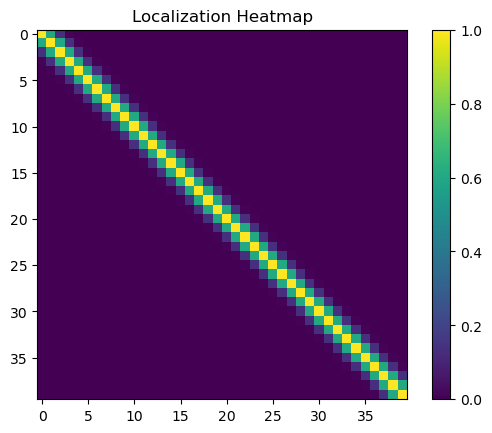

In [13]:
i_indices = np.arange(40)[:, None]  # [[0], [1], [2]]
j_indices = np.arange(40)           # [0, 1, 2]

localization_mat = np.vectorize(cal.localization)(i_indices, j_indices)

plt.imshow(localization_mat, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Localization Heatmap')
plt.show()

In [14]:
class POl:
    def __init__(self, calculation=cal, obs_point=40, method=0):
        self.F = 8.0
        self.N = 40
        self.dt = 0.05
        self.days = 365
        self.day_steps = int(0.20 / self.dt)
        self.time_step = self.days * self.day_steps
        self.ls_time_step = [i for i in range(self.time_step)]
        self.IN = np.eye(self.N)
        self.obs_point = obs_point
        self.df_x_true = pd.read_csv('t_data.csv', header=0, index_col=0)
        self.df_y = pd.read_csv('o_data.csv', header=0, index_col=0)
        self.H = np.eye(self.N)
        self.R = np.eye(self.N)
        self.cal = calculation
        self.method = method
        self.delta = 0.001
        # 以下新変数
        self.member = 1000

    def run_simulation(self):
        x_true = self.df_x_true.values
        y = self.df_y.values
        ua = np.zeros((self.N, self.member))
        uf = np.zeros((self.N, self.member))
        dxf = np.zeros((self.N, self.member))
        error_f, error_a = [], []
        # アンサンブルメンバー作成
        for m in range(self.member):
            # それぞれ初期に乱数擾乱加えてモデル回す
            ua[:, m] = np.random.rand(self.N) + self.F
            for i in range(self.time_step):
                ua[:, m] = self.cal.Rk4(ua[:, m])

        for i in range(self.time_step):
            # forecast step
            for m in range(self.member):
                uf[:, m] = self.cal.Rk4(ua[:, m])
            # 平均計算（axis=1方向の平均）
            mean_uf = np.zeros(self.N)
            for n in range(self.N):
                mean_uf[n] = np.mean(uf[n, :])
            # dxf計算
            for m in range(self.member):
                dxf[:, m] = uf[:, m] - mean_uf
            Pf = 1.1 * localization_mat * ((dxf @ dxf.T) / (self.member - 1))

            # analysis step
            K = Pf @ self.H.T @ np.linalg.inv(self.H @ Pf @ self.H.T + self.R)
            for m in range(self.member):
                # 観測データ作成時に観測誤差分布はnp.random.randとした
                ua[:, m] = uf[:, m] + \
                    K @ ((y[i, :] + np.random.rand(self.N)) -
                         (self.H @ uf[:, m]))
            error_a.append(np.linalg.norm(
                x_true[i, :] - np.mean(ua, axis=1)) / np.sqrt(self.N))
            error_f.append(np.linalg.norm(
                x_true[i, :] - np.mean(uf, axis=1)) / np.sqrt(self.N))

        return error_a, error_f


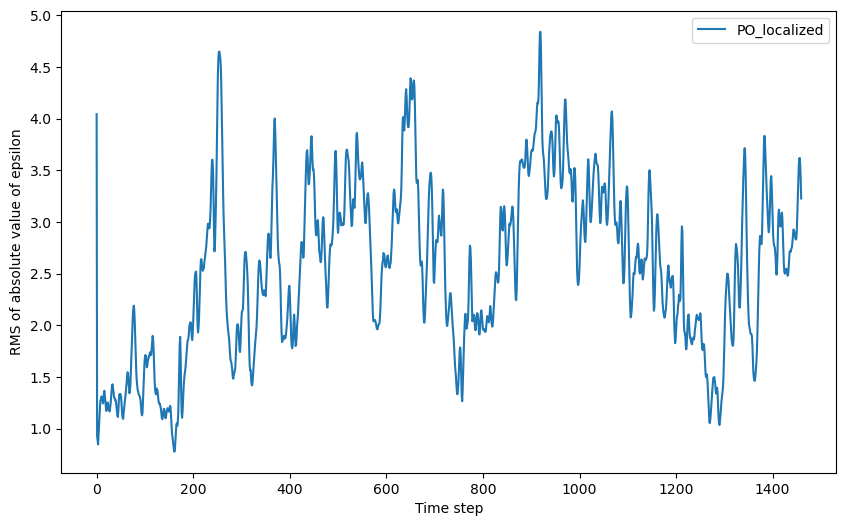

In [15]:
pol = POl()
pol_1, pol_2 = pol.run_simulation()
ls = range(len(pol_2))
plt.figure(figsize=(10, 6))
plt.xlabel('Time step')
plt.ylabel('RMS of absolute value of epsilon')
plt.plot(ls, pol_2, label="PO_localized")
plt.legend()
plt.show()

In [4]:
class SRF:
    def __init__(self, calculation=cal, obs_point=40, method=0):
        self.F = 8.0
        self.N = 40
        self.dt = 0.05
        self.days = 365
        self.day_steps = int(0.20 / self.dt)
        self.time_step = self.days * self.day_steps
        self.ls_time_step = [i for i in range(self.time_step)]
        self.obs_point = obs_point
        self.df_x_true = pd.read_csv('t_data.csv', header=0, index_col=0)
        self.df_y = pd.read_csv('o_data.csv', header=0, index_col=0)
        self.H = np.eye(self.N)
        self.R = np.eye(self.N)
        self.cal = calculation
        self.method = method
        self.delta = 0.001
        self.member = 200
        # 以下新変数
        self.IN = np.eye(self.N)

    def run_simulation(self):
        x_true = self.df_x_true.values
        y = self.df_y.values
        ua = np.zeros((self.N, self.member))
        uf = np.zeros((self.N, self.member))
        ua_mean = np.zeros(self.N)
        uf_mean = np.zeros(self.N)
        dxf = np.zeros((self.N, self.member))
        dyf = np.zeros((self.N, self.member))
        dxa = np.zeros((self.N, self.member))
        error_f, error_a = [], []
        for m in range(self.member):
            ua[:, m] = np.random.rand(self.N) + self.F
            for i in range(self.time_step):
                ua[:, m] = self.cal.Rk4(ua[:, m])
        for i in range(self.time_step):
            # forecast step
            for m in range(self.member):
                uf[:, m] = self.cal.Rk4(ua[:, m])
            # 平均計算（axis=1方向の平均）
            for n in range(self.N):
                uf_mean[n] = np.mean(uf[n, :])
            # dxf計算
            for m in range(self.member):
                dxf[:, m] = uf[:, m] - uf_mean
            dyf = self.H @ dxf

            # analysis step
            K = dxf @ dyf.T @ np.linalg.inv(dyf @
                                            dyf.T + (self.member - 1) * self.R)
            K_fluc = np.eye(self.member) - dyf.T @ np.linalg.inv(dyf @ dyf.T + (self.member - 1) * self.R) @ dyf

            ua_mean = uf_mean + K @ (y[i, :] - self.H @ uf_mean)
            dxa = dxf @ np.sqrt(np.linalg.eigh(K_fluc)[0])
            ua = dxa + ua_mean

            error_a.append(np.linalg.norm(
                x_true[i, :] - ua_mean) / np.sqrt(self.N))
            error_f.append(np.linalg.norm(
                x_true[i, :] - uf_mean) / np.sqrt(self.N))
        return error_a, error_f

In [5]:
srf = SRF()
srf_1, srf_2 = srf.run_simulation()
ls = range(len(srf_2))
plt.figure(figsize=(10, 6))
plt.xlabel('Time step')
plt.ylabel('RMS of absolute value of epsilon')
plt.plot(ls, srf_2, label="SRF")
plt.legend()
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed